In [7]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from tqdm import tqdm
import torch


class ImdbDataset(Dataset):
    def __init__(self, is_train=True):
        # label genre
        with open('dataset/genres.txt', 'r') as f:
            genre_all = f.readlines()
            genre_all = [x.replace('\n','') for x in genre_all]
        self.genre2idx = {genre:idx for idx, genre in enumerate(genre_all)}

    def __getitem__(self, index):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        genre = self.data.iloc[index].genre

        # preprocess text
        if len(self.data) > 1000:
            self.summary = np.load('dataset/mistral_rating_db/summary_embeddings_train.npy')
        else:
            self.summary = np.load('dataset/mistral_rating_db/summary_embeddings_test.npy')

        title_tensor = torch.from_numpy(self.summary[index]).float()
        title_tensor.to(self.device)

        # preprocess image
        img_vec = self.img_vector[index]
        img_tensor = torch.from_numpy(img_vec).float()
        img_tensor.to(self.device)        

        # preprocess label
        genre_vector = np.zeros(len(self.genre2idx))

        for g in genre:
            genre_vector[self.genre2idx[g]] = 1
        genre_tensor = torch.from_numpy(genre_vector).float()
        genre_tensor.to(self.device)

        return title_tensor, img_tensor, genre_tensor

    def __len__(self):
        return len(self.data)

In [8]:
train_data = torch.load('dataset/train_set_vgg19_hf.pt')
test_data = torch.load('dataset/test_set_vgg19_hf.pt')

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

tokenizer = AutoTokenizer.from_pretrained("nickmuchi/distilroberta-base-movie-genre-prediction")
model = AutoModelForSequenceClassification.from_pretrained("nickmuchi/distilroberta-base-movie-genre-prediction")
pipeline = pipeline('feature-extraction', model=model, tokenizer=tokenizer)
# pipeline = pipeline('text-classification', model=model, tokenizer=tokenizer, top_k=None)

res = pipeline("'Batman Returns' is a superhero film directed by Tim Burton and released in 1992. It stars Michael Keaton reprising his role as Bruce Wayne/Batman, alongside Danny DeVito playing the Joker. Set two decades after the events of the previous film (""Batman""), this installment finds Gotham City under threat from both new enemies - Catwoman (played by Michelle Pfeiffer) and the returning villainous Joker. The film received critical acclaim upon release and remains one of the highest-grossing films of all time. Its darker tone and more mature subject matter have had a lasting impact on the Batman franchise, influencing future adaptations and helping to cement its place as one of popular culture's most iconic characters")
res

[[1.8031609058380127,
  0.8620648980140686,
  -0.12129483371973038,
  -0.966647744178772,
  0.6624167561531067,
  -0.9030779004096985,
  -0.6619834303855896,
  -1.9180376529693604,
  1.4222161769866943,
  -0.4344601333141327]]

In [16]:
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

for title, img, genre in train_loader:
    print(title.shape, img.shape, genre.shape)
    break
for title, img, genre in test_loader:
    print(title.shape, img.shape, genre.shape)
    break

torch.Size([32, 10]) torch.Size([32, 1000]) torch.Size([32, 18])
torch.Size([32, 10]) torch.Size([32, 1000]) torch.Size([32, 18])


In [12]:
from torch import nn

class ImdbModel_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1010, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 18),
        )
        self.norm_img = nn.BatchNorm1d(1000)
        self.norm_title = nn.BatchNorm1d(10)


    def forward(self, title, img):
        # normalize
        title = self.norm_title(title)
        img = self.norm_img(img)

        x = torch.cat([title, img], dim=1)
        x = self.fc(x)
        return x
    
model = ImdbModel_2()
model

ImdbModel_2(
  (fc): Sequential(
    (0): Linear(in_features=1010, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=18, bias=True)
  )
  (norm_img): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm_title): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [14]:
from tqdm import tqdm
from torchmetrics.classification import MultilabelF1Score, MultilabelPrecision, MultilabelRecall

num_labels = genre.shape[1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

history = {'train_loss': [], 'test_loss': []}
f1_score = {'train': [], 'test': []}

f1 = MultilabelF1Score(num_labels=num_labels, threshold=0.5, average='macro')
f1 = f1.to(device)
precision = MultilabelPrecision(num_labels=num_labels, threshold=0.5, average='macro')
precision = precision.to(device)
recall = MultilabelRecall(num_labels=num_labels, threshold=0.5, average='macro')
recall = recall.to(device)

def test(model):
    model.eval()
    test_loss = 0
    f1_all = 0
    precision_all = 0
    recall_all = 0

    with torch.no_grad():
        for title, img, genre in test_loader:
            title, img, genre = title.to(device), img.to(device), genre.to(device)
            outputs = model(title, img)
            loss = criterion(outputs, genre)
            test_loss += loss.item()
            
            f1_all += f1(outputs, genre)
            precision_all += precision(outputs, genre)
            recall_all += recall(outputs, genre)

    test_loss /= len(test_loader)
    f1_all /= len(test_loader)
    precision_all /= len(test_loader)
    recall_all /= len(test_loader)

    return test_loss, f1_all, precision_all, recall_all

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for idx, (title, img, genre) in enumerate(tqdm(train_loader)):
        title, img, genre = title.to(device), img.to(device), genre.to(device)
        optimizer.zero_grad()
        outputs = model(title, img)
        loss = criterion(outputs, genre)
        loss.backward()
        optimizer.step()

    train_loss = loss.item()
    test_loss, f1_all, precision_all, recall_all = test(model)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, f1: {f1_all:.4f}, precision: {precision_all:.4f}, recall: {recall_all:.4f}')

100%|██████████| 98/98 [00:04<00:00, 24.21it/s]


Epoch 1/20, train_loss: 7.2555, test_loss: 3.3873, f1: 0.2350, precision: 0.1774, recall: 0.4880


100%|██████████| 98/98 [00:03<00:00, 25.63it/s]


Epoch 2/20, train_loss: 3.3749, test_loss: 3.5465, f1: 0.2480, precision: 0.1852, recall: 0.5204


100%|██████████| 98/98 [00:03<00:00, 24.70it/s]


Epoch 3/20, train_loss: 3.2095, test_loss: 3.3976, f1: 0.2510, precision: 0.1903, recall: 0.4805


100%|██████████| 98/98 [00:03<00:00, 26.82it/s]


Epoch 4/20, train_loss: 3.2008, test_loss: 3.4518, f1: 0.2532, precision: 0.1848, recall: 0.5079


100%|██████████| 98/98 [00:04<00:00, 24.00it/s]


Epoch 5/20, train_loss: 3.5306, test_loss: 3.5874, f1: 0.2663, precision: 0.2010, recall: 0.4904


100%|██████████| 98/98 [00:03<00:00, 25.02it/s]


Epoch 6/20, train_loss: 5.0491, test_loss: 3.9268, f1: 0.2566, precision: 0.1961, recall: 0.4721


100%|██████████| 98/98 [00:04<00:00, 20.96it/s]


Epoch 7/20, train_loss: 1.4448, test_loss: 3.9473, f1: 0.2570, precision: 0.1928, recall: 0.4853


100%|██████████| 98/98 [00:06<00:00, 14.43it/s]


Epoch 8/20, train_loss: 6.2707, test_loss: 4.1166, f1: 0.2736, precision: 0.2144, recall: 0.4832


100%|██████████| 98/98 [00:06<00:00, 14.52it/s]


Epoch 9/20, train_loss: 4.3020, test_loss: 4.3592, f1: 0.2704, precision: 0.2092, recall: 0.4887


100%|██████████| 98/98 [00:05<00:00, 18.73it/s]


Epoch 10/20, train_loss: 6.5709, test_loss: 4.4261, f1: 0.2631, precision: 0.2057, recall: 0.4766


100%|██████████| 98/98 [00:06<00:00, 14.71it/s]


Epoch 11/20, train_loss: 2.1027, test_loss: 4.4254, f1: 0.2543, precision: 0.1923, recall: 0.4696


100%|██████████| 98/98 [00:04<00:00, 21.01it/s]


Epoch 12/20, train_loss: 6.8880, test_loss: 4.9122, f1: 0.2552, precision: 0.1985, recall: 0.4534


100%|██████████| 98/98 [00:07<00:00, 13.85it/s]


Epoch 13/20, train_loss: 2.0772, test_loss: 4.7358, f1: 0.2554, precision: 0.1963, recall: 0.4668


100%|██████████| 98/98 [00:07<00:00, 12.61it/s]


Epoch 14/20, train_loss: 3.7888, test_loss: 4.9339, f1: 0.2697, precision: 0.2065, recall: 0.4899


100%|██████████| 98/98 [00:06<00:00, 15.09it/s]


Epoch 15/20, train_loss: 4.2032, test_loss: 4.8409, f1: 0.2570, precision: 0.1961, recall: 0.4689


100%|██████████| 98/98 [00:05<00:00, 18.72it/s]


Epoch 16/20, train_loss: 1.9669, test_loss: 5.3041, f1: 0.2726, precision: 0.2111, recall: 0.4770


100%|██████████| 98/98 [00:05<00:00, 16.45it/s]


Epoch 17/20, train_loss: 2.7121, test_loss: 5.4537, f1: 0.2655, precision: 0.2058, recall: 0.4861


100%|██████████| 98/98 [00:04<00:00, 22.92it/s]


Epoch 18/20, train_loss: 2.5274, test_loss: 5.5385, f1: 0.2631, precision: 0.2057, recall: 0.4679


100%|██████████| 98/98 [00:04<00:00, 20.06it/s]


Epoch 19/20, train_loss: 7.1517, test_loss: 5.3987, f1: 0.2583, precision: 0.1984, recall: 0.4665


100%|██████████| 98/98 [00:05<00:00, 18.28it/s]


Epoch 20/20, train_loss: 3.2097, test_loss: 5.4426, f1: 0.2737, precision: 0.2044, recall: 0.5022


In [17]:
from xgboost import XGBClassifier
from torchmetrics.classification import MultilabelF1Score
import torch
from sklearn.preprocessing import StandardScaler

X_train = []
y_train = []
for title, img, genre in train_data:
    X_train.append(torch.cat([title, img], dim=0))
    y_train.append(genre)

X_train = torch.stack(X_train)
y_train = torch.stack(y_train)

X_test = []
y_test = []
for title, img, genre in test_data:
    X_test.append(torch.cat([title, img], dim=0))
    y_test.append(genre)

X_test = torch.stack(X_test)
y_test = torch.stack(y_test)

clf = XGBClassifier(n_estimators=200, tree_method='hist', eta=0.1, early_stopping_rounds=20, max_depth=15)
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)

y_pred = clf.predict(X_test)
y_pred = torch.tensor(y_pred)
y_test = torch.tensor(y_test)
f1 = MultilabelF1Score(num_labels=num_labels, threshold=0.5, average='macro')
precision = MultilabelPrecision(num_labels=num_labels, threshold=0.5, average='macro')
recall = MultilabelRecall(num_labels=num_labels, threshold=0.5, average='macro')
print(f1(y_pred, y_test))
print(precision(y_pred, y_test))
print(recall(y_pred, y_test))

[0]	validation_0-logloss:0.61024	validation_1-logloss:0.62060
[10]	validation_0-logloss:0.22298	validation_1-logloss:0.30378
[20]	validation_0-logloss:0.10211	validation_1-logloss:0.22311
[30]	validation_0-logloss:0.05415	validation_1-logloss:0.20117
[40]	validation_0-logloss:0.03276	validation_1-logloss:0.19869
[50]	validation_0-logloss:0.02214	validation_1-logloss:0.20182
[57]	validation_0-logloss:0.01776	validation_1-logloss:0.20502
tensor(0.2829)
tensor(0.4814)
tensor(0.2246)


C:\Users\lg\AppData\Local\Temp\ipykernel_17120\2628080027.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test)


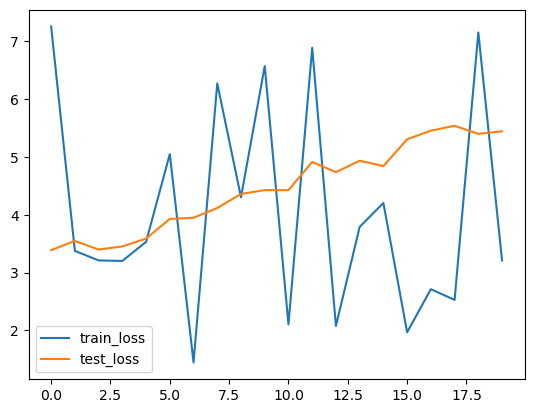

In [18]:
from matplotlib import pyplot as plt
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')
plt.legend()
plt.show()